# <span style="color:orange"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:purple">  Numerical exercises 8</span>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm
M=100000 #number of throws
N=100 #number of blocks
mu = 1
sigma = 0.2
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def psi(x, A, mu, sigma):
    return gaussian(x, A, mu, sigma)+gaussian(x, A, -mu, sigma)

def psi2(x, A, mu, sigma):
    return psi(x, A, mu, sigma)*psi(x, A, mu, sigma)

In Quantum Mechanics, the variational principle asserts that the expectation value of the Hamiltonian operator $\hat{H}$ over a well-chosen trial quantum state ($\Psi_2$ ) serves as a lower bound for the ground state energy ($E_0$):
$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$
In this exercise, we aim to variationally optimize the ground state of a single quantum particle in one-dimensional (1D) space, subject to the external potential:

$$
V(x) = x^4 - \frac{5}{2}x^2
$$
 
Solving this 1D quantum model analytically is not feasible, necessitating the use of numerical methods. To approximate the ground state wave function, the Variational Monte Carlo method employs a trial wave function parametrized by a set of variational parameters. The proposed trial wave function is as follows:

$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$
$\Psi_T^{\sigma,\mu}(x)$ relies on <span style="color:red">two variational parameters: $\sigma$ and $\mu$</span>. These parameters enable us to optimize the trial wave function and subsequently estimate the ground state energy of the quantum system.

## Exercise 8.1

### Implementation of Uniform Metropolis Step for Sampling $\psi^2$



In this exercise, we focus on the implementation of a Uniform Metropolis Step for the purpose of sampling the $\psi^2$. The goal is to efficiently generate samples from the $\psi^2$ probability distribution using the Metropolis algorithm. This process is a crucial component in various computational and quantum mechanical simulations, allowing us to explore and understand the behavior of quantum systems.
Subsequently, we compute the expected value of the previously mentioned Hamiltonian.

Fixing the values of the parameters sigma and mu:
- $\mu = 1$
- $\sigma = 0.2$


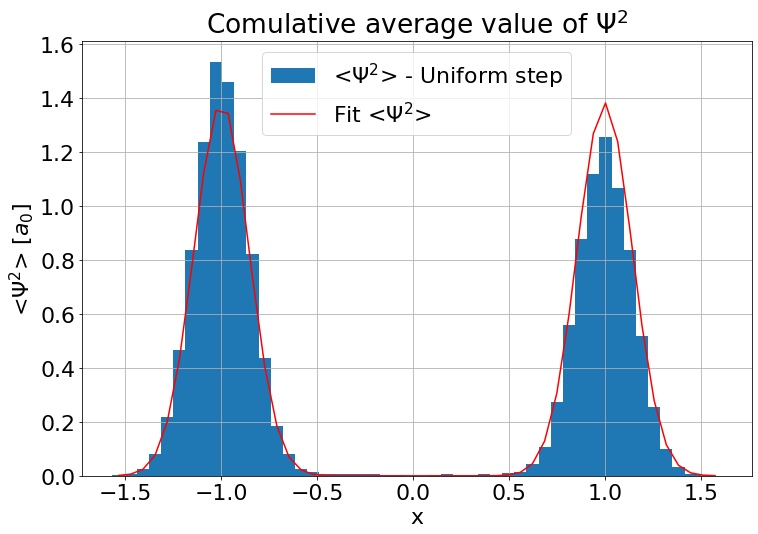

In [6]:
x = np.loadtxt("./data/output_x_psi2_0.dat", usecols=(0), unpack='true')

# Crea un istogramma
hist, bin_edges = np.histogram(x, bins=50, density=True)

# Calcola il punto medio dei bin (valori x) bins center
x_dat = (bin_edges[:-1] + bin_edges[1:]) / 2

# Conteggi dell'istogramma (valori y)
y_dat = hist

plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(12, 8))
plt.title("Comulative average value of $\Psi^2$")
plt.hist(x,bins= 50,label="<$\Psi^2$> - Uniform step",density=True)
#plt.hlines(3/2,0,100,color ="red",label="Analytical value")
plt.xlabel('x')
plt.ylabel('<$\Psi^2$> [$a_0$]')
plt.grid(True)
plt.legend(prop={'size': 20})

#FIT
params, covariance =curve_fit(psi2, x_dat, y_dat, p0=[1, 1, 1])

# Estrai i parametri adattati
A_fit, mu_fit, sigma_fit = params

# Calcola la curva adattata
y_fit = psi2(x_dat, A_fit, mu_fit, sigma_fit)

# Plotta la curva adattata
plt.plot(x_dat, y_fit, 'r-', label='Fit <$\Psi^2$>')

plt.legend()
plt.show()

The sampling has been executed effectively, and the distribution fits quite well.

Here we estimate the average value of the Hamiltonian using the time independent Schrodinger equation: 

$$
{\hat H} \Psi(x) = \left( -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + V(x) \right) \Psi(x) = E \Psi(x)
$$

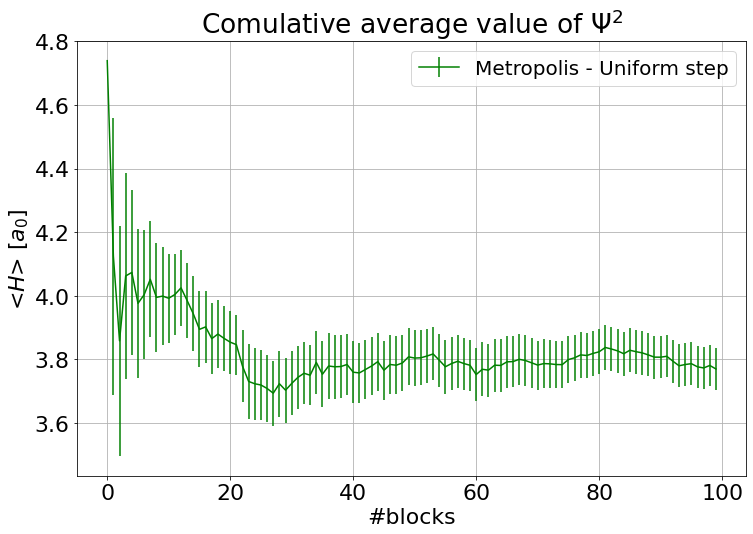

In [7]:
x_unif, rad_unif,rad_unif_err = np.loadtxt("./data/output_H_0.dat", usecols=(0,1,2), unpack='true')

plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(12, 8))
plt.title("Comulative average value of $\Psi^2$")
plt.errorbar(x_unif,rad_unif,yerr=rad_unif_err,color="green",label="Metropolis - Uniform step")
#plt.hlines(3/2,0,100,color ="red",label="Analytical value")
plt.xlabel('#blocks')
plt.ylabel('<$H$> [$a_0$]')
plt.grid(True)
plt.legend(prop={'size': 20})

plt.show()

## Exercise 8.2

### Simulation annealing for $\psi^2$ parameters estimation

Lets now include in the code the Simulaiton Annealing algorthm. 
Simulated annealing is a probabilistic optimization technique inspired by the annealing process in metallurgy, where a material is heated and gradually cooled to reduce defects and achieve a more stable state. In the context of simulation, we use it to find the global optimum (or near-optimum) solution for complex optimization problems.

We used the boltzman distribution law to compute the energy of the sistem and thanks a stocastic flag the optimized parameters for $\mu$ and $\sigma$ are the ones with the minimum energy level.
In order to apply the SA algorithm we made increase the variable $\beta$ which is defined like $\beta = 1/T$. THe range of $\beta$ value is selected in order to mantain the SA acceptance over attempted ratio near to 0.5.

$$\beta \in [1,1000]$$

For each $\beta$ we apply a relax loop of 100 steps. In each step we we compute the Hamiltonian using the 10000 metropolis steps (once for $<H_{old}>_T$ and once for $<H_{new}>_T$). Finally with the probability $P = e^{\beta(<H_{old}>_T-<H_{new}>_T)}$ we select the new parameters which minimized the Hamiltonian.

Below, we show the average Hamiltonians obtained varing $\beta$, namely cooling the system.

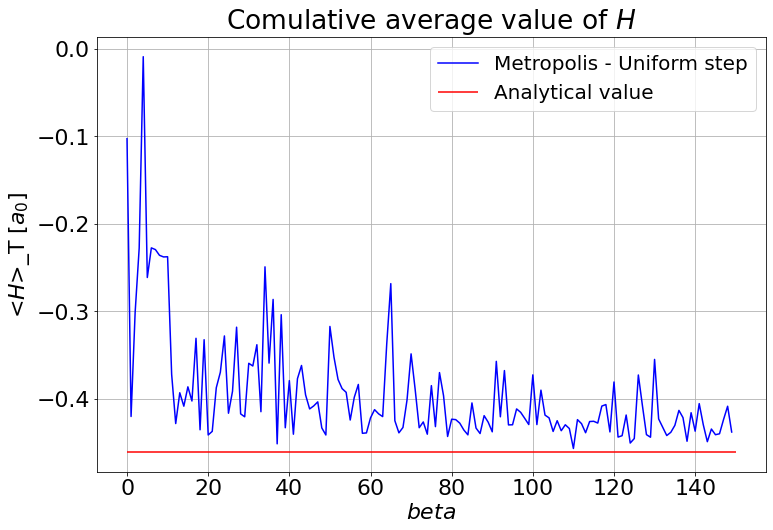

In [8]:
temp,mu, sigma, H = np.loadtxt("./data/out_opt_1.dat", usecols=(0,1,2,3), unpack = True)

plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(12, 8))
plt.title("Comulative average value of $H$")
plt.plot(H,color="blue",label="Metropolis - Uniform step")
plt.xlabel('$beta $')
plt.ylabel('<$H$>_T [$a_0$]')
plt.hlines(-0.46046587969271513,0,len(H),color ="red",label="Analytical value")
plt.grid(True)
plt.legend(prop={'size': 20})

plt.show()

We observe that the Hamiltonian never reach the real minimum given by the analytical calculation. That happen because the Variational Method aims to compute the lower bounded and the fluctions around it and not the minimum in average. On the other hand, we observe a reduction in fluctuation along the $\beta$ axis.

Below we show the behaviour of the wanted parameters along with the cooling process.

best variational parameters:  mu = 0.795222  sigma = 0.612471


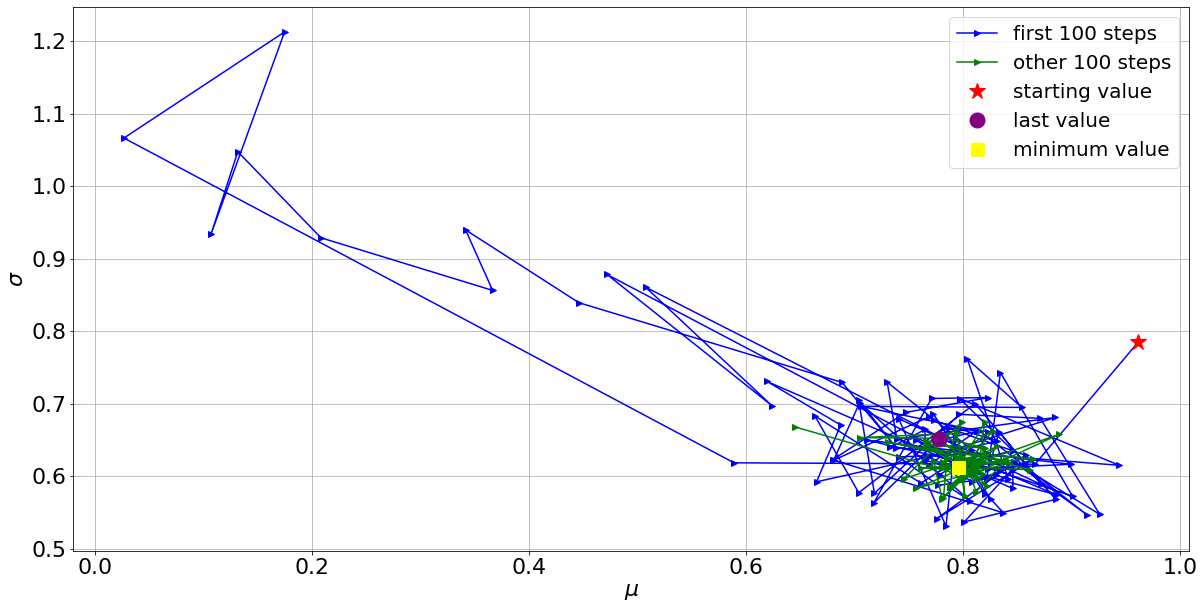

In [9]:
temp,mu, sigma, H = np.loadtxt("./data/out_opt_1.dat", usecols=(0,1,2,3), unpack = True)

min_mu    = mu[np.argsort(H)[0]]
min_sigma = sigma[np.argsort(H)[0]]

print("best variational parameters:  mu =",min_mu , " sigma =",min_sigma )


fig = plt.figure( figsize = (20,10) )
plt.plot(mu[:100],sigma[:100], "->" , color = "blue", label = "first 100 steps")
plt.plot(mu[100:],sigma[100:], "->" , color = "green" , label = "other 100 steps")
plt.plot(mu[0] , sigma [0] , "*",markersize="17", color = 'red' ,label = "starting value")
plt.plot(mu[-1] , sigma [-1] ,"o",markersize="15", color = 'purple', label = "last value")
plt.plot(min_mu,min_sigma,"s",markersize="13", color = 'yellow',label = "minimum value")
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.grid(True)
plt.legend(fontsize = 20)
plt.show()

Once we have the optimized parameters we can apply the code of the exercise 8.1 and compute with the metropolis step the Ground state energy.

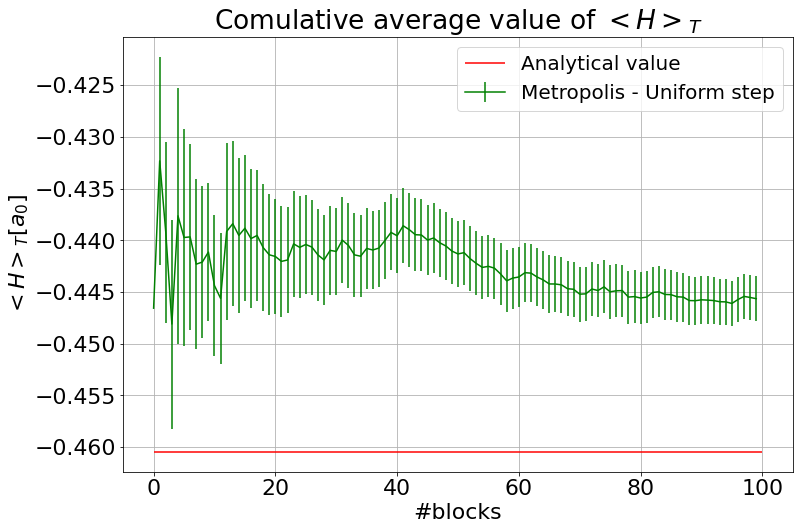

In [77]:
x_unif, rad_unif,rad_unif_err = np.loadtxt("./data/output_H_1.dat", usecols=(0,1,2), unpack='true')

plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(12, 8))
plt.title("Comulative average value of $<H>_T$")
plt.errorbar(x_unif,rad_unif,yerr=rad_unif_err,color="green",label="Metropolis - Uniform step")
plt.hlines(-0.46046587969271513,0,100,color ="red",label="Analytical value")
plt.xlabel('#blocks')
plt.ylabel('$<H>_T [a_0]$')
plt.grid(True)
plt.legend(prop={'size': 20})

plt.show()

Our result does not align with the value obtained through the solution of the Schrödinger equation in matrix form. This discrepancy arises from our deliberate choice of the trial wave function, which was intended to yield a satisfactory solution rather than the optimal one. To achieve a more accurate solution, we should investigate the problem using a different trial function.

Ground state energy:  -0.46046587969259045
1st excited state energy:  0.09742471331819892
2nd excited state energy:  1.9717331343930118


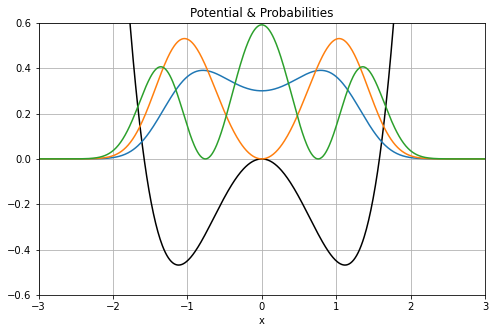

In [3]:
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,Psi = np.linalg.eigh(H)

# Take the transpose & normalize
Psi = np.transpose(Psi)
Psi = Psi/np.sqrt(dx)

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

# Plot a few things
plt.figure(figsize=(8,5))
scale = 0.3
plt.plot(x, scale*V, color="Black", label="Potential") # plot the potential
plt.plot(x,(Psi[0])**2)
plt.plot(x,(Psi[1])**2)
plt.plot(x,(Psi[2])**2)
plt.title("Potential & Probabilities")
plt.xlabel("x")
plt.grid(True)
plt.xlim((-3,3))
plt.ylim((-0.6,0.6))
plt.show()

In [95]:
x


array([-1.20834211e-20,  1.38256282e-20,  5.34826781e-21,  3.79617913e-20,
       -1.52392622e-20,  4.28374041e-21,  1.35541630e-21, -7.37802566e-21,
       -1.72957785e-20,  5.47706759e-20, -3.72710580e-20, -6.98793729e-21,
       -1.38132654e-20, -6.70292647e-20,  2.64208112e-21, -3.66701196e-20,
        3.84679239e-22, -6.70584946e-20, -1.61550338e-19, -2.12903850e-19,
       -1.58319205e-19, -1.94437060e-19, -1.69696698e-19, -2.52557695e-19,
       -2.46486399e-19, -3.83638802e-19, -3.17095620e-19, -2.67909194e-19,
       -2.26122186e-19, -2.21452819e-19, -7.17567685e-20, -1.50573765e-20,
        3.15353240e-20,  1.27834144e-19,  2.88362601e-19,  4.57749381e-19,
        7.33191557e-19,  9.36457963e-19,  1.23794253e-18,  1.65572263e-18,
        1.97291040e-18,  2.67433863e-18,  3.53063633e-18,  4.74377600e-18,
        6.15632112e-18,  8.22188024e-18,  1.09366941e-17,  1.43506056e-17,
        1.89631547e-17,  2.49029489e-17,  3.25876228e-17,  4.27293418e-17,
        5.58189457e-17,  

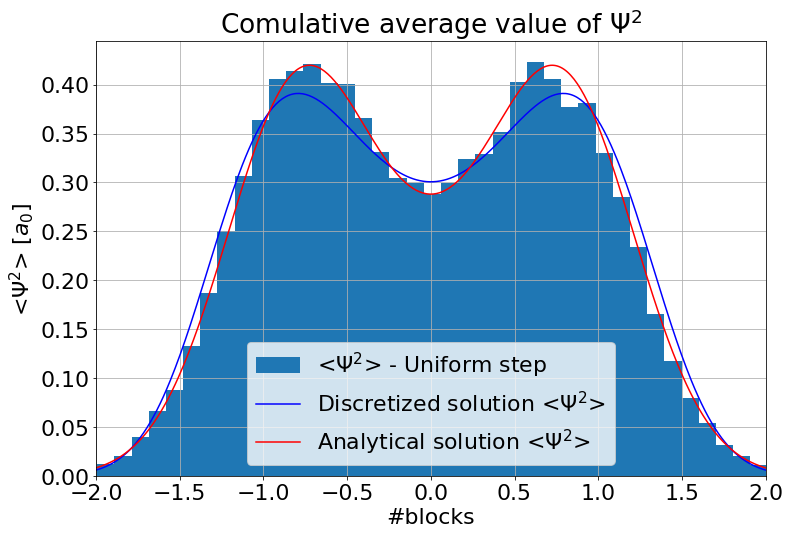

In [18]:
def psi2_an(x, mu , sigma):
    a = (x-mu)/sigma
    b = (x+mu)/sigma
    norm = 2*np.sqrt(np.pi) *sigma*(1 + np.exp(-(mu/sigma)**2)) 
    return (np.exp(-0.5*( a**2) ) + np.exp(-0.5* b**2))**2 /norm

x = np.loadtxt("./data/output_x_psi2_1.dat", usecols=(0), unpack='true')

# Crea un istogramma
hist, bin_edges = np.histogram(x, bins=50, density=True)

# Calcola il punto medio dei bin (valori x) bins center
x_dat = (bin_edges[:-1] + bin_edges[1:]) / 2

# Conteggi dell'istogramma (valori y)
y_dat = hist

plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(12, 8))
plt.title("Comulative average value of $\Psi^2$")
plt.hist(x,bins= 50,label="<$\Psi^2$> - Uniform step",density=True)
#plt.hlines(3/2,0,100,color ="red",label="Analytical value")
plt.xlabel('#blocks')
plt.ylabel('<$\Psi^2$> [$a_0$]')
plt.grid(True)
plt.legend(prop={'size': 20})
plt.xlim(-2,2)
#FIT
params, covariance =curve_fit(psi2, x_dat, y_dat, p0=[1, 1, 1])

# Estrai i parametri adattati
A_fit, mu_fit, sigma_fit = params

# Calcola la curva adattata
y_fit = psi2(x_dat, A_fit, mu_fit, sigma_fit)

# Plotta la curva adattata
#plt.plot(x_dat, y_fit, 'r-', label='Fit <$\Psi^2$>')

#Plot Discretized values.
plt.plot(np.linspace(-a/2, a/2, N),(Psi[0])**2, 'b-', label='Discretized solution <$\Psi^2$>')

#Plot Discretized values.
plt.plot(np.linspace(-a/2, a/2, N),psi2_an(np.linspace(-a/2, a/2, N),min_mu,min_sigma), 'r-', label='Analytical solution <$\Psi^2$>')

plt.legend()
plt.show()